# Low rank approximation of time dependent matrices

*Author: Håkon Noren*

*Date: 13.12.2020*

## Introduction

*This notebook presents a method to obtain a low rank approximation of time dependent matrices; the dynamic low rank approximation proposed by Koch and Lubich [2]. In order to evaluate the performance of this method, an alternative method for computing the singular value decomposition, proposed by Golub and Kahan [1], is presented. Both methods are compared to the native SVD algorithm implemented in the Numpy library, relying on highly accurate and efficient LAPACK routines.*

## 1. SVD from Lanczos bidiagonalization

Assume one is aiming at computing the singular value decomposition of $A \in \mathbb{R}^{m \times n}$ with $n\leq m$, meaning we find $A = U\Sigma V^T$ with $U,V$ orthonormal matrices with the left and right eigenvectors of $A^TA$ and $\Sigma = \text{diag}(\sigma_1,\cdots,\sigma_n)$, a diagonal matrix of the singular values in descending order.

The algorithm proposed by Golub and Kahan first uses the Lanczos bidiagonalization algorithm to first compute the decomposition $A = PBQ^T$ where $B$ is lower bidiagonal and $P,Q$ orthonormal. An important sidenote on the bidiagonalization, is the issue of ensuring orthogonality of $P,Q$. By using a reorthogonalization procedure (similar to Arnoldi) of the vectors $v_i$ of $P$ one is able to prevent propagating rounding errors that elsewise would ruin orthogonality. 

As summarized in Golub and Loan p. 516 [1], an algorithm similar to the shifted QR-iteration is applied implicitly to $B^TB$ yielding the SVD $B = U_B\Sigma V_B^T$. The final decomposition of $A$ is then given by

\begin{align}
A = PU_B\Sigma V_B^TQ^T
\end{align}

In the same manner as one can construct a truncated SVD with a lower rank than the original matrix $\text{Rank}(A_k) = k \leq n$ on the form $A_k = \sum_{i = 1}^k \sigma_iu_iv_i^T$, this is feasible with the proposed algorithm by stopping the Lanczos bidiagonalization algorithm at $k \leq n$, yielding $A \approx P_kB_kQ_k^T$ and furthermore computing the SVD of the bidiagonal $B_k$.

### 1.1 Numerical experiments

The performance of this approach to the SVD is now compared to the default LAPACK routines, provided by Numpy. Three different approaches to generating random matrices is presented. Assume that $\eta \in [0,1)$ is a random number from an uniform distribution, and furthermore that $\eta_{n,m} \in \mathbb{R}^{n \times m}$ is a matrix constructed by independent random numbers $\eta$. In all cases we construct test cases with square matrices, $A \in \mathbb{R}^{n \times n}$.

1. `random_identity(n)` constructs $A = \eta_{n,n}$
2. `random_outer(n)` by taking the outerproduct, constructs $A = \eta_{n,10},\eta_{n,10}^T$ for $n\geq 10$, hence $\text{rank}(A) \approx  10$
3. `random_singular_values(n)` first finds the SVD of $\eta_{n,n} = USV^T$, generates $\Sigma = \text{diag}(\eta_n)$ and finally constructs $A = U\Sigma V^T$.


### 1.2 Accuracy 

Let $W_k = P_kU_B\Sigma V_B^TQ_k^T \approx A$ be the SVD computed from Lanczos bidiagonalization and the shifted QR factorization. Let $X_k \approx A$ be the best approximation to $A$ with rank $k$, i.e. the SVD of $A$ using LAPACK routines. We now measure the accuracy of the proposed algorithm by plotting the approximation errors for integers $k = k_{min},\cdots,k_{max}$ for all experiments described above. We consider the following approximation errors:

1. $\|\sigma_{X(k)} - \sigma_{Y(k)}\|_2$ the difference between the singular values of the two algorithms with a rank $k$ approximation.
2. $\|A - X_k\|_F$ the approximation error of the best approximation $X_k$ with rank $k$ in Frobenious norm.
3. $\|A - W_k\|_F$ the approximation error of the SVD from Lanczos bidiagonalization $W_k$ with rank $k$ in Frobenious norm.

Finally we consider the orthogonality error of the approximations to the orthonormal matrices with left and right eigenvectors $U \approx \bar U = P_kU_B$ and $V \approx \bar V = Q_kV_B$. We measure the orthogonality error by taking

\begin{aligned}
e_V &= \|\bar V^T\bar V - I\|_F \\
e_U &= \|\bar U^T\bar U - I\|_F \\
\end{aligned}

By finding the orthogonality error when running Lanczos bidiagonalization with and without reorthogonalization on the three approaches to generating random matrices above, we are able to investigate the effects of reorthogonalization.

In [1]:
import numpy as np
from bidiag_svd import experiment_lanczos

random_identity = lambda n: np.random.rand(n,n)
random_outer = lambda n: np.random.rand(n,10)@np.random.rand(n,10).T

def random_singular_values(n):
    S = np.diag(np.random.rand(n)*0.7+0.3)
    U,S1,V = np.linalg.svd(np.random.rand(n,n))
    return U@S@V.T 

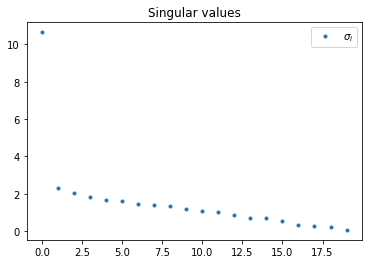

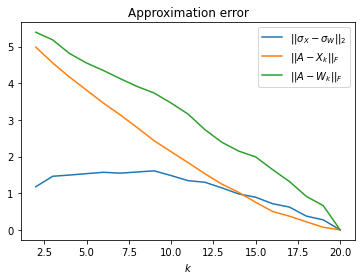

||A-W_n||_F =  3.0841265952053706e-06


In [2]:
n = 20
ks = np.arange(2,n+1,1,dtype=int)
experiment_lanczos(n,ks,random_identity)

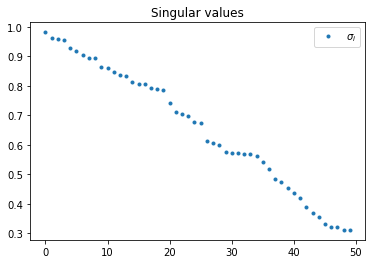

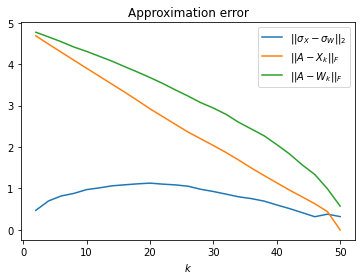

||A-W_n||_F =  0.5741227105079578


In [3]:
n = 50
ks = np.arange(2,n+1,2,dtype=int)
experiment_lanczos(n,ks,random_singular_values)

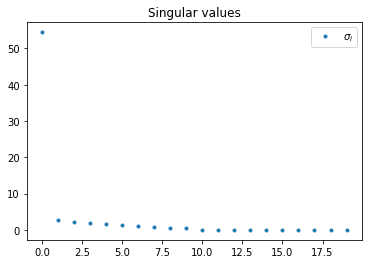

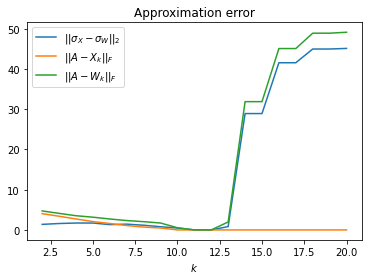

||A-W_n||_F =  49.120132059857355


In [4]:
n = 20
ks = np.arange(2,n+1,1,dtype=int)
experiment_lanczos(n,ks,random_outer)

From the three experiments above, the following should be noted:

1. For the first case $W_k$ converges towards the best approximation $X_k$ for $k \rightarrow n$.
2. In the second case, it seems like we have convergence, but the difference between $W_k$ and $X_k$ for $k = n$ is significantly larger than for the previous case.
3. Finally when $k$ gets larger than the rank of the matrix we are approximating, it seems like the bidiagonal SVD completely breaks down. However, it approximates $X_k$ reasonably well when $k$ is lower than the rank of the matrix.

However, in all the three cases there is a significant deviation between the Lanczos SVD and the LAPACK implementation for $2<k<n$, to the order of $O(1)$. By studying the singular values from both algorithms, the largest singular values are similar, while the smaller singular values approximated by Lanczos SVD deviates from the LAPACK implementation. By studying figures 4. - 11. in [3], in which the Lanczos SVD is tested in a similar way, we observe an error on the same order for some experiments. 

In [5]:
from bidiag_svd import experiment_orthogonality
n = 30
k = 10
n_exp = 50

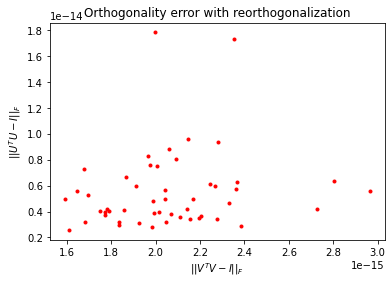

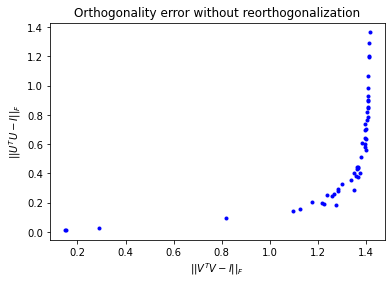

In [6]:
experiment_orthogonality(n,k,n_exp,random_identity)

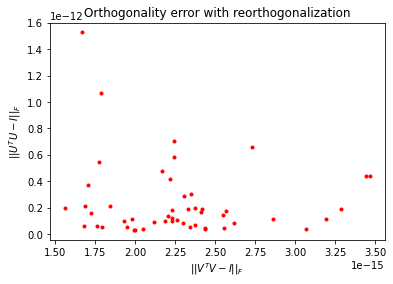

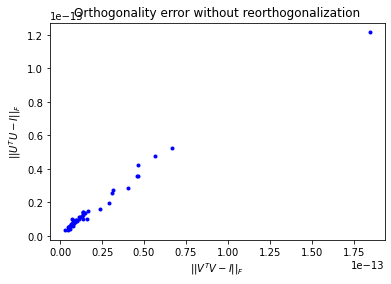

In [7]:
experiment_orthogonality(n,k,n_exp,random_singular_values)

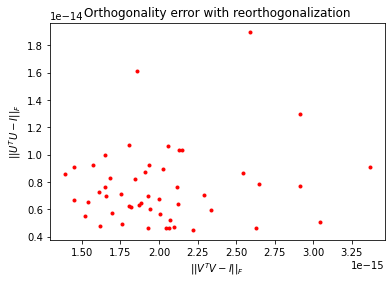

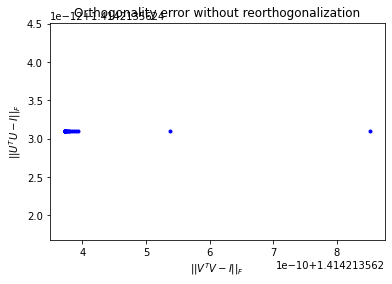

In [8]:
experiment_orthogonality(n,k,n_exp,random_outer)

We use the same three random matrix functions to check orthogonality. We set $n = 30$, $k = 10$ and perform $n_{exp} = 50$ experiments.

In all cases, reorthogonalization is able to ensure orthogonal $P_k,Q_k$. In the first case, with $A = \eta_{n,n}$ the bidiagonal SVD without reorthogonalization fails to ensure orthogonality with error to the order of $O(1)$. In the two other cases the error without reorthogonalization is much closer to machine precision, but somewhat larger than the error we achieve with reorthogonalization. It seems like the orthogonality errors without reorthogonalization almost lies on some curve in the $(e_V,e_U)$ space, suggesting that the orthogonality error of $U$ and $V$ has some dependence. This is not unreasonable, considering how $P_k,Q_k$ is constructed using the Lanczos bidiagonalization algorithm. However, getting a deeper understanding why this is the case, could be interesting for further investigations. 

## 2. Dynamic low rank approximation

Again we assume one aims to find a low rank approximation of a matrix $A$ with the additional assumption that this matrix is depending on a parameter $t$, which in many applications would represent time. Meaning we have a matrix $A(t)$, which we furthermore assume is differentiable with respect to $t$, and hence one can find $\dot A(t)$. 

### 2.1 Differential equations for the low rank approximation

Instead of finding $X(t)$ of rank $k$ such that we minimize $\|X(t) - A(t)\|_F$, we find the optimal $Y(t)$ of rank $k$ such that $\|\dot Y(t) - \dot A(t)\|_F$ is minimized. As we can find a decomposition $Y = USV^T$ with $U,V$ orthonormal, proposition 2.1 in Koch and Lubic [2] gives the following decomposition of the derivative $\dot Y$

\begin{align}
\dot Y &= \dot USV^T + U\dot SV^T + US\dot V^T \\
\\
\text{where } \; \dot S &= U^T\dot AV\\
\dot U &= (I - UU^T)\dot A V S^{-1}\\
\dot V &= (I - VV^T)\dot A^T U S^{-T}\\
\end{align}

where we require that $U^T\dot U = V^T\dot V = 0$.

### 2.2 Second order scheme

In order to obtain a numerical solution to the equation above, a method based on a Runge-Kutta method of order two will be used. We discretize the time by $t_j = jh$ and denoting $A(t_j) := A_j$. A first order scheme of the equations above is given on the form

\begin{align}
S_{j+1} &= S_j + hU_j^T\dot A_j V_j\\
U_{j+1} &= \text{cay}\big(h(F_{U_j}U_j^T - U_jF_{U_j}^T) \big)U_j \\
V_{j+1} &= \text{cay}\big(h(F_{V_j}V_j^T - V_jF_{V_j}^T) \big)V_j \\
\\
\text{where } \;
F_{U_j} :&= (I - U_jU_j^T)\dot A_j V_j S_j^{-1} \\
F_{V_j} :&= (I - V_jV_j^T)\dot A_j^T U_j S_j^{-T} \\
\end{align}

Hence we can find the rank $k$ approximation $Y_j = U_jS_jV_j^T$. Note that here we only provided the first order scheme. The form of the second order scheme could be seen in the code (`dynamic_low_rank.py`/`rk2()`).

### 2.3 Step size controll

As one could expect that the error in the second order scheme is not constant with respect to time $t$, a way to adjust the step size $h$ could improve the accuracy and efficiency of the method. We obtain an approximation to the error in step $j$ by comparing the solution by the first order scheme to the solution of the second order scheme. If the error is above a certain tolerance, we reduce the stepsize, yielding increased accuracy. In the same manner, if the error is far below the tolerance, the step size is increased, yielding increased efficiency.

### 2.4 Maintaining orthogonality with Cayley transformations

Maintaining orthogonality of $U,V$ in every timestep is crucial and of this reason the Cayley transformation is utilized. Indeed, it could be proved that if $B$ is a $m \times m$ skew symmetric matrix and $U$ $m \times k$ has orthonormal columns, then $\bar U = \text{cay}(B)U$ has orthonormal columns. The transform is given by

\begin{align}
\text{cay}(B) &= \big(I - \frac{1}{2}B\big)^{-1}\big(I + \frac{1}{2}B\big) & (0)
\end{align}

In our case we have, for $C = [F_U,-U], D = [U,F_U]$ that $B = CD^T$ and a similar decomposition for $V,F_V$. We can prove the following three alternative forms of $\text{cay}(CD^T)$:

\begin{align}
\text{cay}(CD^T) &= I + C(I-\frac{1}{2}D^TC)^{-1}D^T &(1) \\
\end{align}


From the QR-factorization $U^{\perp}R_{2,2} = F_U$ we get

\begin{align}
    \text{cay}(CD^T) &= I + [U,U^{\perp}]\begin{bmatrix}
      0&-R^T_{2,2}\\
      R_{2,2}&0
    \end{bmatrix}
    \biggl(I-\frac{1}{2}
    \begin{bmatrix}
      0&-R^T_{2,2}\\
      R_{2,2}&0
    \end{bmatrix}
    \biggl)^{-1}[U,U^{\perp}]^T & (2)
  \end{align}

By further decomposing the Cayley transformation in $(1)$, we find

\begin{align}
K_1 &= (-2I - \frac{1}{2}F_U^TF_U)^{-1}\\
K_2 &= (I - \frac{1}{4}F_U^TF_U)^{-1}\\
\text{cay}(CD^T) &= I + C
\begin{bmatrix}
-2K_1 & K_1\\
2(K_2-I) & K_2
\end{bmatrix}
D^T &(3) \\
\end{align}


A short comment on the complexity of these methods is necessary. In our case, we have that $C,D \in \mathbb{R}^{m \times 2k}$ as $U,F_U \in\mathbb{R}^{m \times k}$. This means that $CD^T = F_UU^T - UF_U^T \in \mathbb{R}^{m \times m}$. The Cayley transform requires us to take the inverse, of a matrix of the same size as its argument. Furthermore, the inverse function of Numpy, from the Linalg library relies on the DGESV routine of Lapack which is a fast implementation of a LU-factorization with complexity $O(n^3)$ [4]. Hence the naive implementation of the Cayley transformation, seen in $(0)$ yields a complexity (not considering matrix products) of $O(m^3)$. In equation $(1)$ and $(2)$ we get a complexity of $O(k^3)$. Seens we are aiming at construcing low rank approximations, one has that $0<k\leq m$. Hence for lower rank, the alternative Cayley transformations could be expected to run more efficiently.

### 2.5 Accuracy

With $Y_{k,j}$ being the dynamic low rank approximation at time $t_j$ we can find the approximation error by comparing it to $A_j,X_{k,j}$. We can also measure the error in the derivatives, i.e. $\|A_{k,j} - Y_{k,j}\|_F$. By also plotting $\|A-W_k\|_F$ and $\|A-X_k\|_F$ we can compare the Dynamic low rank approximation to the accuracy of the best approximation of rank $k$ derived from LAPACK and by Lanczos bidiagonalization described above.

### 2.6 Numerical experiments

We will propose three ways to generate time dependent matrices $A(t)$ where there exists a derivative $\dot A(t)$. Where it should be noted that the two last methods are similar as to what is done in [2]. By using these tests, we can assess the accuracy of the dynamic low rank method suggested above.

Let $A_0 = \eta_{nk} \eta_{nk}^T, k\leq n$ and $L \in \mathbb{R}^{n \times n}$ be two-dimensional discrete Laplacian operating on the domain $\Omega = [0,1]\times[0,1]$. Then the first test matrix is given by

\begin{align}
A_1(t) &= \exp(tL)A_0 &(1)
\end{align}

where $\exp$ is the matrix exponential. Furthermore let the two skew symmetric Toeplitz matrices $T_1,T_2$ with bands for $T_1$ given by $[-1,0,1]$ and for $T_2$ by $[-2,-1,0,1,2]$. Let now $Q_i = \exp(tT_i), i = 1,2$. Finally let $A_1,A_2 \in \mathbb{R}^{100 \times 100}$ be random matrices given by $\epsilon \eta_{100,100}$ where $\epsilon$ is a scaling parameter. We also add $B_0 = \frac{1}{2}\eta_{10,10} + I_{10}$ as the leading $10 \times 10$ block for $A_1,A_2$. $I_{10}$ is the identity matrix.

This yields the second test matrix

\begin{align}
A_2(t) &= Q_1(t)(A_1 + e^tA_2)Q_2(t)^T &(2)
\end{align}

Finally the third test is similar to the above from, only with a different time dependence

\begin{align}
A_3(t) &= Q_1(t)(A_1 + \cos(t)A_2)Q_2(t)^T &(3)
\end{align}

We ensure comparability between the experiments by setting the same seed for the random generator when generating $A_1,A_2$. This makes sure that the same random matrices are being used between different experiments.

#### Experiment 1

We aim to approximate 

\begin{align}
A_1(t) &= \exp(tL)A_0 \\
\dot A_1(t) &= L\exp(tL)A_0 
\end{align}

Choosing $A_0,L \in \mathbb{R}^{m \times m}$ with $m = 5^2$. Furthermore we set $k = 2$ and $t \in [0,1]$.

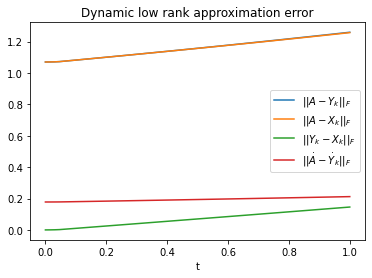

In [9]:
%matplotlib inline
from dynamic_low_rank import get_A1
from dynamic_low_rank import run_test

l = 5
k = 10
m = l**2
h0 = 1e-3
t0 = 0
T = 1
tol = 1e-3

A1,A1dot = get_A1(m,l,k)
run_test(A1,A1dot,k,h0,t0,T,tol,compare_W = False)

The dynamic low rank approximation is indeed fairly close to the best approximation, but one could notice that $\|Y_k-X_k\|_F$ increases over time, as would be expected by a Runge-Kutta scheme where the local error in every step contributes to increasing global error. 

#### Experiment 2

We aim to approximate 

\begin{align}
A_2(t) &= Q_1(t)(A_1 + e^tA_2)Q_2(t)^T \\
\dot A_2(t) &= T_1 A_2(t) + A_2(t)T_2^T + Q_1(t)(e^tA_2)Q_2(t)^T
\end{align}

We have that $A_2(t),\dot A_2(t) \in \mathbb{R}^{n \times n}$ with $n = m^2 = 10^2$ and perform the four experiments given by the different parameters $\epsilon = 10^{-1},10^{-4}$ and $k = 10,20$ as done in [2].

In [10]:
from dynamic_low_rank import get_A2,get_Ai
from dynamic_low_rank import run_test

h0 = 1e-3
t0 = 0
T = 1
tol = 1e-4
m = 10

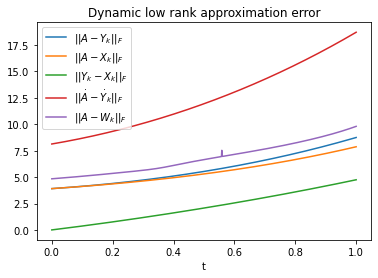

In [11]:
epsilon = 1e-1
k = 10

A2,A2dot = get_A2(epsilon,m)
run_test(A2,A2dot,k,h0,t0,T,tol)

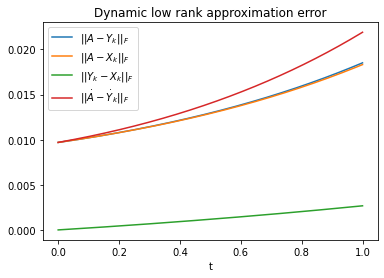

In [12]:
epsilon = 1e-4
k = 10

A2,A2dot = get_A2(epsilon,m)
#We omit comparing with W_k in this case
#as the error gets very large, rendering the plot unreadable.
run_test(A2,A2dot,k,h0,t0,T,tol,compare_W=False)

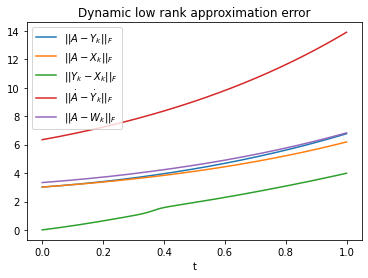

In [13]:
epsilon = 1e-1
k = 20

A2,A2dot = get_A2(epsilon,m)
run_test(A2,A2dot,k,h0,t0,T,tol)

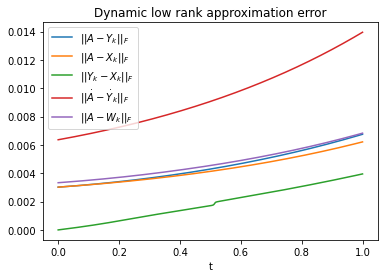

In [14]:
epsilon = 1e-4
k = 20

A2,A2dot = get_A2(epsilon,m)
run_test(A2,A2dot,k,h0,t0,T,tol)

In the error plots above we observe that the difference between the dynamic low rank approximation and the best approximation, $\|Y_k - X_k\|_F$ seems to decrease as we decrease $\epsilon$. This is in line with the results observed in [2]. It could be understood by considering $\epsilon$ as controlling the amount of noise in the matrices we are approximating. With larger $\epsilon$ and with increasing time, the noise in $A_2$ dominates more and is poorly approximated by the dynamic low rank approximation compared to the SVD by LAPACK. Below we visualize this by plotting the matrices $A_2(t = 0.5)$ for $\epsilon = 10^{-1},10^{-4}$.

We also observe some decrease in $\|A - Y_k\|_F$ when going from $k = 10$ to $k = 20$. This is as expected, as increasing $k$ should yield a better approximation. 

It is also worth to comment the size of the error of the derivatives $\|\dot A - \dot Y_k \|_F$. It is somewhat large compared to the other errors, however if we find the relative error, i.e. 

\begin{align}
\frac{\|\dot A - \dot Y_k \|_F}{ \|\dot A\|_{\infty}}
\end{align}

we notice that it is more to the same order as the other relative errors. Which is more in line with the derivation of this algorithm, as we are aiming at minimizing the approximation error of the low rank approximation of the derivative of $A$.

The performance of the Lanczos SVD, measured by $\|A - W_k \|_F$ is in line with the observations done in section 1. We indeed notice that the dynamic low rank approximation is more accurate in the cases studied for $t \in [0,T]$.

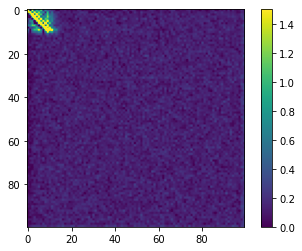

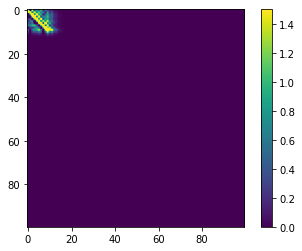

In [15]:
from dynamic_low_rank import get_A2
import matplotlib.pyplot as plt

m = 10
t = 0.5

epsilon = 1e-1
A2,A2dot = get_A2(epsilon,m)
plt.imshow(A2(t),vmin=0,vmax=1.5)
plt.colorbar()
plt.show()

epsilon = 1e-4
A2,A2dot = get_A2(epsilon,m)
plt.imshow(A2(t),vmin=0,vmax=1.5)
plt.colorbar()
plt.show()

#### Experiment 3

We now aim to approximate 

\begin{align}
A_3(t) &= Q_1(t)(A_1 + \cos(t)A_2)Q_2(t)^T \\
\dot A_2(t) &= T_1 A_2(t) + A_2(t)T_2^T - Q_1(t)(\sin(t)A_2)Q_2(t)^T
\end{align}

We have that $A_2(t),\dot A_2(t) \in \mathbb{R}^{n \times n}$ with $n = m^2 = 10^2$ and perform the two experiments given by the different parameters $\epsilon = 10^{-1}$ and $k = 5,20$.

In [16]:
from dynamic_low_rank import get_A3
from dynamic_low_rank import run_test

h0 = 1e-4
t0 = 0
T = 6
tol = 1e-3
m = 10
epsilon = 1e-1

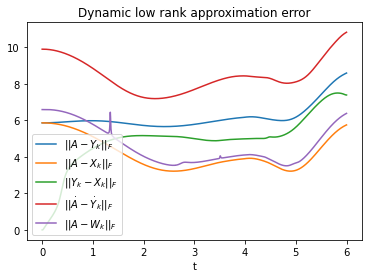

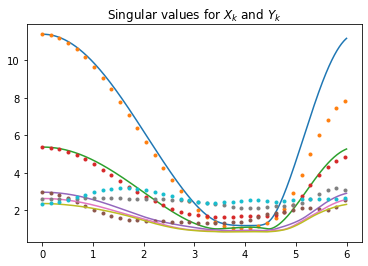

In [17]:
k = 5

A3,A3dot = get_A3(epsilon,m)
run_test(A3,A3dot,k,h0,t0,T,tol,plot_singular = True)

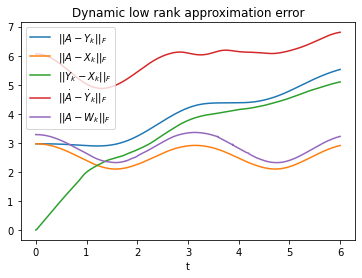

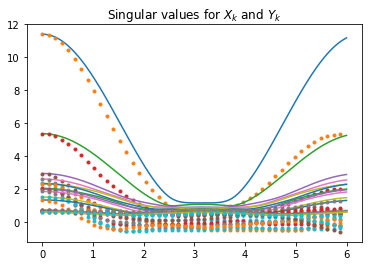

In [18]:
k = 20

A3,A3dot = get_A3(epsilon,m)
run_test(A3,A3dot,k,h0,t0,T,tol,plot_singular = True)

In the plots above, the dots represent the approximation of $k$ singular values by the dynamic low rank algorithm. The lines represent the best approximation (SVD) of the $k$ largest singular values. 

In this experiment we observe that this implementation of the dynamic low rank approximation fails when compared to the best approximation. $\|Y_k - X_k\|_F$ grows quickly with time. The cause of this failure is most likely due to the fact that the dynamic low rank approximation fails to capture the fact that the singular values change order (as they are ordered in decreasing order), yielding a discontinous SVD. We can show that this is true by studying the construction of $A_3(t)$

\begin{align}
A_3(t) = Q_1(t)\bigg(A_1 + \cos(t)A_2\bigg)Q_2^T(t)
\end{align}

which, as $Q_1(t),Q_2(t)$ is orthogonal, will have singular values to the order of

\begin{align}
\sigma(t)_i \sim \sigma_i(A_1) + \cos(t)\sigma_i(A_2)
\end{align}

As we have $t>0$, it is evident that the ordering of the singular valuer in the SVD will change as $\cos(t)$ changes sign, in addition to the fact that $A_1,A_2$ have singular values to the order of $O(1)$ by construction.

A similar example is presented and discussed in [2] and studying figure 3.3, when setting $r = k = 20$, the dynamic low rank approximation seems to approximate the singular values well. In our experiement this is not the case, which could result either from the fact that the numerical experiments differ somewhat, or that our implementation is less accurate.

### Implementing fast Cayley transformations

Below follows numerical experiments of the three different Cayley transformations discussed in section 2.4., including the naive approach without trying to reduce the dimension of the matrices being inverted. We run experiments for matrices $A_1(t=0.5)$ of increasing sizes. Then, for each $m_i \in \{10,12,\cdots,30\}$ we get a system of equations of size $\mathbb{R}^{n \times n}$, $n = m^2$. For each problem we run one Runge-Kutta step of order two, where we use the four different methods to do the Cayley transformation. We use the `time()` library of Python to estimate the runtime and provide a plot of this below. Time is plotted with a logarithmic scale on the y-axis.

We also check the accuracy of the different implementations by taking the difference between the Cayley transform with the naive implementation and the three variations (measured in Frobenious norm).

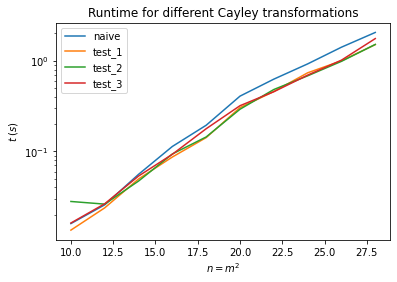

Accuracy of method 1:  1.0665961828384094e-14
Accuracy of method 2:  1.0665961864597271e-14
Accuracy of method 3:  8.123932931745656e-09


In [19]:
from dynamic_low_rank import experiment_cayley
import numpy as np
ms = np.arange(10,30,2)

k = 5
experiment_cayley(ms,k,"A1")

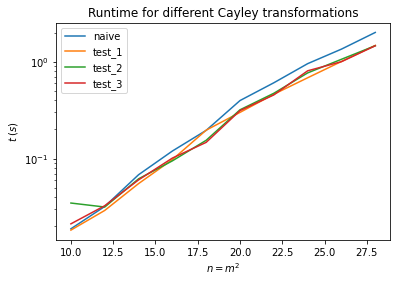

Accuracy of method 1:  1.0973381082828314e-14
Accuracy of method 2:  1.0973381815908573e-14
Accuracy of method 3:  2.1817862431962977e-08


In [20]:
k = 30
experiment_cayley(ms,k,test_matrix="A1")

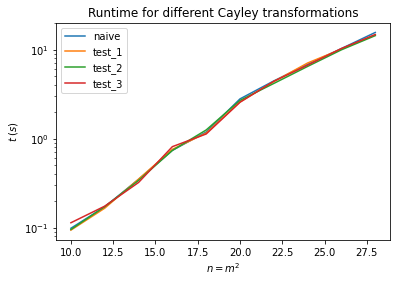

Accuracy of method 1:  1.091698136368713e-14
Accuracy of method 2:  1.1040022081765979e-14
Accuracy of method 3:  9.849964048369884


In [21]:
k = 5
experiment_cayley(ms,k,test_matrix="A2")

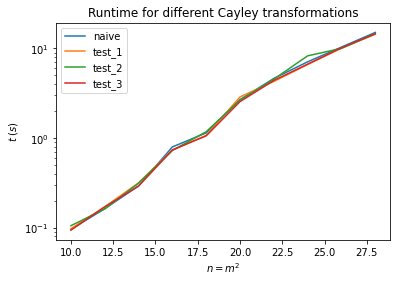

Accuracy of method 1:  1.2765066724565391e-14
Accuracy of method 2:  1.5330866530673684e-14
Accuracy of method 3:  421.15091577049805


In [22]:
k = 30
experiment_cayley(ms,k,test_matrix="A2")

The above experiment support the idea that some gains in efficiency could be made, however it is not entirely clear which implementation of the Cayley transformation is most efficient. 

The gains in efficiency are not very significant and there is little difference between the three different implementations that deviate from the naive approach, especially for test matrix $A_2(t)$. Considering the accuracy of the transformation, method 1, in addition to the slightly poorer performance of method 2, method 1 would be a natural choice. And this is indeed the transformation that has been used in the dynamic low rank implementations above.

It should also be noted that it seems like method 3 is not implemented properly, due to its complete lack of accuracy.

## Bibliography

<a name="foot1">[1]</a>  G.H. Golub and C.F. Van Loan, *Matrix Computations*, Johns Hopkins Studies in the Mathematical Sciences.

<a name="foot1">[2]</a> O. Koch and C.Lubic *Dynamical low-rank approximartion* SIAM J. on Matrix Anal. and Appl. (2007), DOI 10.1137/050639703.

<a name="foot1">[3]</a> H.D. Simon and H. Zha, *Low-rank matrix approximation using the Lanczos bidiagonalization process with applications*, SIAM J. Sci. Comp., vol 6 (2000), pp 2257–2274.


<a name="foot1">[4]</a> Blackford, Susan, *LAPACK Benchmark* published 1999-10-01, URL : http://www.netlib.org/lapack/lug/node71.html